--- INITIATING INFRASTRUCTURE INTEGRATION ---
1️⃣  Loading Raw SRTM: ../data/raw/srtm/N19W105.hgt
✅ Terrain Model: 148598 cells centered on Port.

2️⃣  Querying Infrastructure (OSM)...
✅ Retrieved 4214 Buildings & 104 Industrial Zones.

3️⃣  Fusing Layers...
💾 MASTER DATA SAVED: ../data/processed/manzanillo_MASTER_TWIN_DATA.csv

4️⃣  Generating Satellite Intelligence Map...


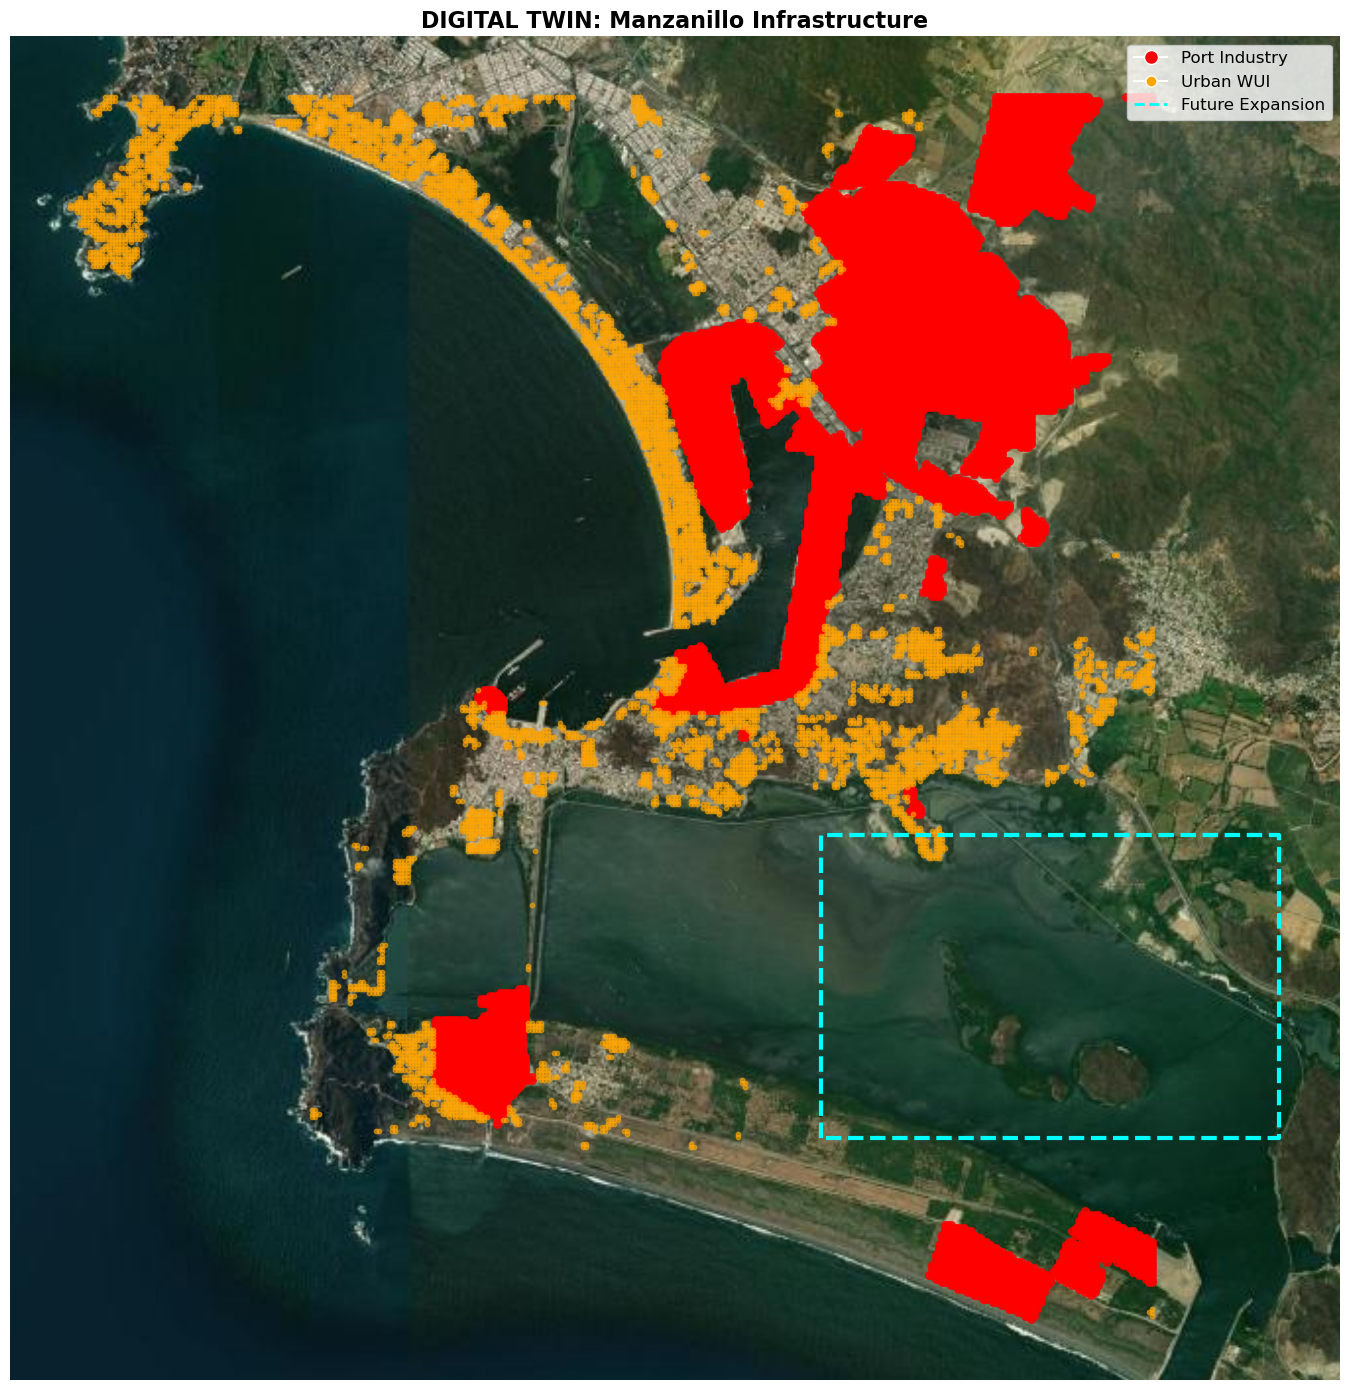

In [16]:
# =============================================================================
# 07_Infrastructure_Integration.ipynb
# PHASE: REPAIR & FUSION
# OBJECTIVE: Regenerate Terrain (Fix 12km Gap) & Fuse WUI Infrastructure
# =============================================================================

# --- 1. INSTALL & IMPORT ---
try:
    import contextily as ctx
except ImportError:
    import subprocess
    print("Installing contextily...")
    subprocess.check_call(["pip", "install", "contextily"])
    import contextily as ctx

import rasterio
from rasterio.windows import from_bounds
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import Point, Polygon
import osmnx as ox
import os
import warnings

warnings.filterwarnings("ignore")

# --- 2. CONFIGURATION ---
PORT_LAT = 19.052
PORT_LON = -104.315
RADIUS_KM = 6
UTM_CRS = "EPSG:32613"   # Metric
VIS_CRS = "EPSG:3857"    # Satellite

# Path Handling
BASE_DIR = '../' if os.path.exists('../data') else ''
RAW_DEM_PATH = BASE_DIR + 'data/raw/srtm/N19W105.hgt'
OUTPUT_CSV = BASE_DIR + 'data/processed/manzanillo_MASTER_TWIN_DATA.csv'

print("--- INITIATING INFRASTRUCTURE INTEGRATION ---")

# --- 3. REGENERATE TERRAIN (FIX OFFSET) ---
try:
    print(f"1️⃣  Loading Raw SRTM: {RAW_DEM_PATH}")
    with rasterio.open(RAW_DEM_PATH) as src:
        deg_radius = RADIUS_KM / 111.0
        minx, miny = PORT_LON - deg_radius, PORT_LAT - deg_radius
        maxx, maxy = PORT_LON + deg_radius, PORT_LAT + deg_radius
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        elevation_data = src.read(1, window=window)
        
        # Calculate Slope
        gy, gx = np.gradient(elevation_data, 30.0)
        slope_rad = np.arctan(np.sqrt(gx**2 + gy**2))
        slope_deg = np.degrees(slope_rad)
        
        # Create Grid
        transform = src.window_transform(window)
        height, width = elevation_data.shape
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')
        
        lons = np.array(xs).flatten()
        lats = np.array(ys).flatten()
        elevs = elevation_data.flatten()
        slopes = slope_deg.flatten()
        
        mask = elevs > -1000 
        env_data = pd.DataFrame({
            'latitude': lats[mask], 'longitude': lons[mask],
            'elevation': elevs[mask], 'slope': slopes[mask]
        })
        
        # Defaults
        env_data['fuel_model'] = 'Vegetation'
        env_data['wind_speed'] = 15.0
        env_data['wind_direction'] = 225.0
        env_data['is_structure'] = 0
        env_data['priority_boost'] = 1.0
        
    print(f"✅ Terrain Model: {len(env_data)} cells centered on Port.")

except FileNotFoundError:
    print(f"❌ CRITICAL: SRTM file missing at {RAW_DEM_PATH}.")
    raise

# --- 4. ACQUIRE INFRASTRUCTURE ---
print(f"\n2️⃣  Querying Infrastructure (OSM)...")
try:
    buildings = ox.features_from_point((PORT_LAT, PORT_LON), tags={'building': True}, dist=RADIUS_KM*1000)
    ind_tags = {'landuse': ['industrial', 'port', 'depot'], 'man_made': ['storage_tank', 'works']}
    industrial = ox.features_from_point((PORT_LAT, PORT_LON), tags=ind_tags, dist=RADIUS_KM*1000)
    
    # Project to UTM
    if not buildings.empty: buildings = buildings.to_crs(UTM_CRS)
    if not industrial.empty: industrial = industrial.to_crs(UTM_CRS)
    print(f"✅ Retrieved {len(buildings)} Buildings & {len(industrial)} Industrial Zones.")
except Exception as e:
    print(f"⚠️ OSM ERROR: {e}")
    buildings, industrial = gpd.GeoDataFrame(), gpd.GeoDataFrame()

# --- 5. FUSE DATA ---
print(f"\n3️⃣  Fusing Layers...")
geom = [Point(xy) for xy in zip(env_data.longitude, env_data.latitude)]
geo_env = gpd.GeoDataFrame(env_data, geometry=geom, crs="EPSG:4326").to_crs(UTM_CRS)

# Fuse WUI
geo_env['cell_geom'] = geo_env.geometry.buffer(20)
geo_env = geo_env.set_geometry('cell_geom')

if not buildings.empty:
    idx_urb = gpd.sjoin(geo_env, buildings, how='inner', predicate='intersects').index.unique()
    env_data.loc[idx_urb, 'fuel_model'] = 'Urban_WUI'
    env_data.loc[idx_urb, 'is_structure'] = 1

if not industrial.empty:
    idx_ind = gpd.sjoin(geo_env, industrial, how='inner', predicate='intersects').index.unique()
    env_data.loc[idx_ind, 'fuel_model'] = 'Industrial_Port'
    env_data.loc[idx_ind, 'priority_boost'] = 10.0

# Future Expansion
expansion_coords = [(19.045, -104.290), (19.045, -104.250), (19.020, -104.250), (19.020, -104.290)]
future_poly = Polygon([(lon, lat) for lat, lon in expansion_coords])
future_gdf = gpd.GeoDataFrame({'geometry': [future_poly]}, crs="EPSG:4326").to_crs(UTM_CRS)
idx_fut = gpd.sjoin(geo_env, future_gdf, how='inner', predicate='intersects').index.unique()
env_data.loc[idx_fut, 'is_future_expansion'] = 1

env_data.to_csv(OUTPUT_CSV, index=False)
print(f"💾 MASTER DATA SAVED: {OUTPUT_CSV}")

# --- 6. SATELLITE VISUALIZATION (With Fix) ---
print("\n4️⃣  Generating Satellite Intelligence Map...")
fig, ax = plt.subplots(figsize=(14, 14))

# Reproject for Web Mercator (Satellite)
viz_gdf = geo_env.to_crs(VIS_CRS)
viz_future = future_gdf.to_crs(VIS_CRS)

# Define Masks
mask_industrial = env_data['fuel_model'] == 'Industrial_Port'
mask_wui = env_data['fuel_model'] == 'Urban_WUI'

# Plot Port Industry (Red) - Using Centroids
if mask_industrial.any():
    subset = viz_gdf[mask_industrial]
    ax.scatter(subset.geometry.centroid.x, subset.geometry.centroid.y, 
               c='red', s=30, alpha=0.8, label='Port Industry (High Risk)')

# Plot Urban WUI (Orange) - Using Centroids
if mask_wui.any():
    subset = viz_gdf[mask_wui]
    ax.scatter(subset.geometry.centroid.x, subset.geometry.centroid.y, 
               c='orange', s=10, alpha=0.6, label='Urban Interface (WUI)')

# Plot Future Expansion
viz_future.plot(ax=ax, facecolor='none', edgecolor='cyan', linewidth=3, linestyle='--', label='Future Expansion Zone')

# Add Satellite Basemap
try:
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, attribution=False)
except Exception as e:
    print(f"⚠️ Map Tile Error: {e}")

# Labels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Port Industry', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='Urban WUI', markersize=8),
    Line2D([0], [0], color='cyan', linestyle='--', linewidth=2, label='Future Expansion')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=12)
ax.set_title("DIGITAL TWIN: Manzanillo Infrastructure", fontsize=16, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()